In [14]:
import matplotlib.pyplot as plt
import random, time
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库

In [ ]:
# dq的核心在于重复利用历史数据, 有点类似于先动态规划中的先收敛价值评估

In [15]:
class CliffWalkingEnv:
    def __init__(self, nrow, ncol):
        self.nrow = nrow
        self.ncol  = ncol

        # curent agent position
        self.x = 0
        self.y = self.ncol-1

    def step(self, action):
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        
        reward = -1  # f(next_state)
        
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            # 如果不是在终点的话奖励为-100，如果到了终点，虽然奖励还是-1，但是就可以停止了，不用增加负奖励了，因此也是agent喜欢的地方
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):
        self.x = 0
        self.y = self.nrow-1
        # one-dimension pos
        return self.y * self.ncol+self.x

In [16]:
class DynaQ:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action, n_planning):
        # 这里用np初始化，便于调用argmax等接口
        self.Q_table = np.zeros([nrow * ncol, n_action])  
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n_planning = n_planning
        self.model = dict() # 环境模型

    # 选取下一步的操作,具体实现为epsilon-贪婪
    def take_action(self, state):  
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  
        # 输入 state,返回最大值对应的动作
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    # qlearning 核心函数
    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中保存, 冲突的话会保存最新的
        for _ in range(self.n_planning):
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)
    

In [37]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol=ncol, nrow=nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    n_action = 4
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_action, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return agent, env, return_list

Q-planning步数为：0


Iteration 9: 100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 3526.80it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 2061.45it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 436.96it/s, episode=300, return=-13.400]


Q-planning步数为：50


Iteration 9: 100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 210.77it/s, episode=300, return=-13.000]


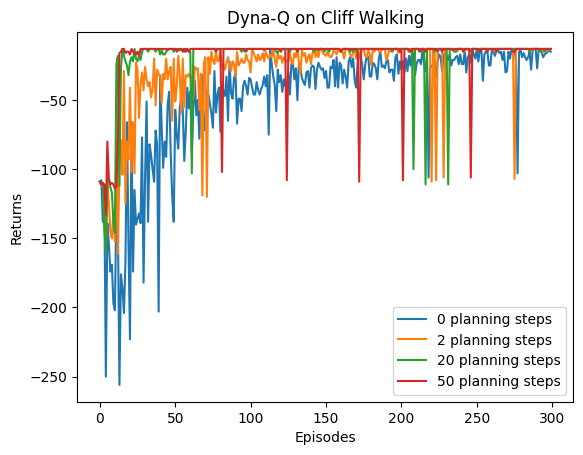

In [42]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20, 50]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    agent, env, return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

In [43]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# 我们可以发现，如果greedy=0，即采取完全的贪心策略，模型最终收敛的有问题，在原点采取向上的非法动作，如果增加随机0.1则可以解决这个问题，也可以用greedy-decay

Sarsa算法最终收敛得到的策略为：
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [44]:
agent.Q_table

array([[  -7.94108868,   -7.71232075,   -7.94108868,   -7.71232075],
       [  -7.71232075,   -7.45813417,   -7.94108868,   -7.45813417],
       [  -7.45813417,   -7.17570464,   -7.71232075,   -7.17570464],
       [  -7.17570464,   -6.86189404,   -7.45813417,   -6.86189404],
       [  -6.86189404,   -6.5132156 ,   -7.17570464,   -6.5132156 ],
       [  -6.5132156 ,   -6.12579511,   -6.86189404,   -6.12579511],
       [  -6.12579511,   -5.6953279 ,   -6.5132156 ,   -5.6953279 ],
       [  -5.6953279 ,   -5.217031  ,   -6.12579511,   -5.217031  ],
       [  -5.217031  ,   -4.68559   ,   -5.6953279 ,   -4.68559   ],
       [  -4.68559   ,   -4.0951    ,   -5.217031  ,   -4.0951    ],
       [  -4.0951    ,   -3.439     ,   -4.68559   ,   -3.439     ],
       [  -3.439     ,   -2.71      ,   -4.0951    ,   -3.439     ],
       [  -7.94108868,   -7.45813417,   -7.71232075,   -7.45813417],
       [  -7.71232075,   -7.17570464,   -7.71232075,   -7.17570464],
       [  -7.45813417,   -6.861894